# Tutorial 3 - Generating metacells for reverse-engineering of ARACNe gene regulatory networks 

This tutorial explores different approaches to generate metacells from scRNA-seq data. Metacells are used as a means to counteract sparsity in single-cell transcriptomics and improve gene regulatory network (GRN) inference, for instance using the [ARACNe3](https://github.com/califano-lab/ARACNe3) and [ARACNe-AP](https://pubmed.ncbi.nlm.nih.gov/27153652/) algorithms for GRN reconstruction by mutual information estimation. After a brief description of the pyVIPER installation procedure and the modules needed, this notebook is organized in the following sections.

**Table of Contents**

[Step 1. Load a gene expression matrix and associated metadata](#1)\
[Step 2. Perform basic preprocessing and clustering](#2)\
[Step 3. Generate metacells](#3)\
[Key Takeaways](#4) 

### Install Pyviper
Install `pyviper` from PyPI using pip. Alternatively, refer to the README in the current GitHub to install from the local directory.

In [1]:
#!pip install viper-in-python

### Import modules
Load `pyviper` and additional modules required used in this tutorial.

In [2]:
import pyviper
import scanpy as sc
import anndata 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc_context
from sklearn.metrics import silhouette_samples

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # for jit decorator issue with sc.pp.neighbors (09/30/2023)

/Users/lucazanella7/mambaforge/envs/pyviper_development/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1. Load a gene expression matrix and associated metadata
<a id='1'></a>
Load the same gene expression matrix (UMIs) used in Tutorial 2 and store it into an [AnnData](https://anndata.readthedocs.io/en/latest/) object to enable interoperability with [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/#). Cells used in this tutorial were sampled from scRNA-seq data published in [Peng et al., 2019](https://www.nature.com/articles/s41422-019-0195-y).  

Display matrix dimensions (cells x genes)

In [3]:
gExpr_url = "https://zenodo.org/records/10059791/files/Tutorial_2_counts_mixed_4632.tsv.gz" # path to gene expression matrix (UMI counts)
adata_gExpr = pd.read_csv(gExpr_url, sep="\t") # read from remote 
adata_gExpr = sc.AnnData(adata_gExpr) # convert to AnnData object

adata_gExpr

AnnData object with n_obs × n_vars = 4632 × 24005

Load cell-associated metadata.

In [4]:
metadata_url = "https://zenodo.org/records/10059791/files/Tutorial_2_metadata_mixed_4632.tsv.gz" # path to cells metadata
cells_metadata = pd.read_csv(metadata_url, sep="\t")  # load it

Store the metadata in the `adata_gExpr` object and display the observation annotation.

In [5]:
adata_gExpr.obs = pd.merge(adata_gExpr.obs, cells_metadata, how="left",left_index=True, right_index=True) # store cell-specific metadata as annotation observation
adata_gExpr.obs.head()

,Cell_Type
T1_AACCATGCACAACTGT,Ductal cell type 2
T1_AAGACCTAGTCATGCT,Ductal cell type 2
T1_ACATACGAGACTCGGA,Ductal cell type 2
T1_ACCAGTATCTTGCAAG,Ductal cell type 2
T1_ACGATGTTCACGAAGG,Ductal cell type 2


The observation annotations include the patient from which each cell was sequenced and the annotated cell type. List the number of cells for each cell types.

In [6]:
adata_gExpr.obs.groupby('Cell_Type').size().reset_index(name='n') # show cell types and number of cells for each type in AnnData

,Cell_Type,n
0,B cell,1000
1,Ductal cell type 2,1455
2,Fibroblast cell,1277
3,Stellate cell,900


### Step 2. Perform basic preprocessing and clustering
<a id='2'></a>
Perform some standard preprocessing. The UMI matrix can be processed using the standard Scanpy preprocessing workflow. Since the quality of the provided data was pre-assessed and found to be high, cell filtering will be minimal. For a more detailed explanation of quality control steps, refer to the preprocessing tutorials by [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) or [Seurat](https://satijalab.org/seurat/articles/pbmc3k_tutorial). 

In [7]:
sc.pp.calculate_qc_metrics(adata_gExpr, inplace=True)
sc.pp.filter_cells(adata_gExpr, min_genes=200) # filter out cells with <200 genes expressed
sc.pp.filter_genes(adata_gExpr, min_counts=10) # filter out genes that are present with <10 UMIs

#adata_gExpr = calcMitoRiboPercent(adata_gExpr)
#adata_gExpr = filterCellsHighMito(adata_gExpr,0.2)

# Store UMI in .raw
adata_gExpr.raw = adata_gExpr

sc.pp.normalize_total(adata_gExpr, inplace=True,target_sum=1e4)
sc.pp.log1p(adata_gExpr)
sc.pp.highly_variable_genes(adata_gExpr, flavor="seurat", n_top_genes=3000, inplace=True)

sc.pp.scale(adata_gExpr)

scRNA-seq data are known to exhibit high sparsity, typically >80-90%. Compute the sparsity of cells labelled as Fibroblasts as the percentage of zero-entries in the dataset.

In [8]:
Fibroblast_matrix = adata_gExpr[adata_gExpr.obs['Cell_Type'] == 'Fibroblast cell']
sparsity = np.mean(Fibroblast_matrix.raw.X == 0)
del Fibroblast_matrix

print("Sparsity (fibroblasts, single cells): " + str(round(sparsity,2)*100) + "%")



Sparsity (fibroblasts, single cells): 85.0%


### 3. Generate Metacells 
<a id='3'></a>
Compute a distance matrix between each pair of cells on the PCA-projected space in the dataset using the `corr_distance` function. Any distance matrix can be used for metacell  generation by setting 'dist_slot' to the corresponding value in the `repr_metacells` function (see below).

In [9]:
sc.tl.pca(adata_gExpr, svd_solver='arpack', random_state=0)
pyviper.pp.corr_distance(adata_gExpr) # compute correlation distance

100%|██████████| 5/5 [00:00<00:00, 41.37it/s]


Generate a set of metacell matrices for each cellular population (cluster), as represented by the 'Cell_Type' annotation in .obs. The metacell generation function allows several combination of inputs. Specifically, exactly two of the following parameters must be set: 
**1.** 'size', **2a.** 'min_median_depth' or **2b.** 'n_cells_per_metacell', **3a.** 'perc_data_to_use' or **3b.** 'perc_incl_data_reused'. 

<u>Please notice that 2a-2b and 3a-3b are mutually exclusive, i.e. they cannot be set together.</u>

- **Example 1**: generate 400 metacells per cell population requiring an attempt minimum depth of 12,000 UMI/metacell.

In [10]:
n_metacells=400
min_target_depth=12000

pyviper.pp.repr_metacells(adata_gExpr, 
                          counts=None, 
                          pca_slot='X_pca', 
                          dist_slot='corr_dist', 
                          size=n_metacells, 
                          min_median_depth=min_target_depth, 
                          clusters_slot="Cell_Type",
                          key_added="metacells_approach_1")  # size=n_meta, n_cells_per_metacell=k, clusters_slot="putative_tumor_infercnv_output"

100%|██████████| 2/2 [00:00<00:00, 138.68it/s]<00:02,  1.25it/s]
/Users/lucazanella7/mambaforge/envs/pyviper_development/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lucazanella7/mambaforge/envs/pyviper_development/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lucazanella7/mambaforge/envs/pyviper_development/lib/python3.12/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lucazanella7/mambaforge/envs/pyviper_development/lib/python3.12/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/lucazanella7/mambaforge/envs/pyviper_development/lib/python3.12/site

While the generation of the minimum target depth cannot be guaranteed in all cases, pyVIPER attempts to satisfy this request by tuning the number of nearest neighbors used in metacell generation. 

Display `adata_gExpr`.

In [11]:
adata_gExpr

AnnData object with n_obs × n_vars = 4632 × 18160
    obs: 'Cell_Type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'metacells_approach_1_B cell', 'metacells_approach_1_Ductal cell type 2', 'metacells_approach_1_Fibroblast cell', 'metacells_approach_1_Stellate cell'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'corr_dist'

4 new matrices, one for each cell type, were stored as Pandas dataframe in `adata.uns`. 

Display the metacell matrix for the population of Ductal cell type 2. 

In [12]:
adata_gExpr.uns["metacells_approach_1_Ductal cell type 2"]

,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,LINC00115,FAM41C,RP11-54O7.3,SAMD11,NOC2L,...,RP11-332K15.1,RP11-157E21.1,DMRT2,RP11-309M23.1,NLRP7,IGLL1,EGFR-AS1,RSPO2,KCNC2,AGTR2
metacell_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
metacell_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
metacell_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
metacell_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
metacell_4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
metacell_395,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
metacell_396,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
metacell_397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
metacell_398,0,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each metacell matrix can be used as input to ARACNe3 to reverse engineer the corresponding GRN which can then be provided as an input to VIPER. Each metacell matrix is associated with a dictionary collecting relevant metacell statistics. 

Display metacell-associated statistics for the population of fibroblasts.

In [13]:
attrs_dict = adata_gExpr.uns["metacells_approach_1_Fibroblast cell"].attrs
attrs_df = pd.DataFrame.from_dict(attrs_dict, orient='index', columns=['Values']) # convert to df

attrs_df


,Values
size,400.000000
n_cells_per_metacell,2.000000
min_median_depth,12000.000000
median_depth,18332.000000
perc_total_samples_used,58.339859
perc_included_samples_used_mult_times,7.248322
mean_n_times_samples_used,1.073826
stdev_n_times_samples_used,0.266571


The report is highly informative. The metacell matrix contains 400 metacells, each generated by aggregation of 2 nearest neighbors after requesting an "attempt" minimum target depth of 12,000 UMI/metacell. The median depth for the inferred metacells is ~18,000 UMI/metacell. 58% of the original single-cells from the fibroblasts population was used for metacell generation, with <7% of cells being aggregated in more than 1 metacell. 

The data sparsity is expected to be decreased in the metacells.

In [14]:
sparsity = np.mean(np.array(adata_gExpr.uns["metacells_approach_1_Fibroblast cell"]) == 0)
print("Sparsity (fibroblasts, metacells example 1): " + str(round(sparsity,2)*100) + "%")


Sparsity (fibroblasts, metacells example 1): 77.0%


Display the statistics for metacells of another cluster (B cells).

In [15]:
attrs_dict = adata_gExpr.uns["metacells_approach_1_B cell"].attrs
attrs_df = pd.DataFrame.from_dict(attrs_dict, orient='index', columns=['Values']) # convert to df

attrs_df


,Values
size,400.000000
n_cells_per_metacell,3.000000
min_median_depth,12000.000000
median_depth,11481.500000
perc_total_samples_used,81.700000
perc_included_samples_used_mult_times,31.456548
mean_n_times_samples_used,1.468788
stdev_n_times_samples_used,0.855148


As mentioned before, `repr_metacells` allows several combinations of parameters. Let's consider another combination.

- **Example 2**: generate 400 metacells per cluster such that each metacell should incorporate 20 single-cells (`n_cells_per_metacell=20`; `min_median_depth=None`).


In [16]:
n_cells_per_metacell=20

pyviper.pp.repr_metacells(adata_gExpr, 
                          counts=None, 
                          pca_slot='X_pca', 
                          dist_slot='corr_dist', 
                          size=400,
                          n_cells_per_metacell=n_cells_per_metacell,
                          min_median_depth=None, 
                          clusters_slot="Cell_Type",
                          key_added="metacells_approach_2") 

cluster metacells: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Display metacell-associated statistics for the Fibroblast population. The median depth is expected to be much higher than before, due to the larger number of cells per metacells specified.

In [17]:
attrs_dict = adata_gExpr.uns["metacells_approach_2_Fibroblast cell"].attrs
attrs_df = pd.DataFrame.from_dict(attrs_dict, orient='index', columns=['Values']) # convert to df

attrs_df


,Values
size,400.000000
n_cells_per_metacell,20.000000
min_median_depth,NaN
median_depth,196897.500000
perc_total_samples_used,97.259201
perc_included_samples_used_mult_times,91.384863
mean_n_times_samples_used,6.441224
stdev_n_times_samples_used,4.286650


Data sparsity is also strongly decreased due to the higher number of nearest neighbors being aggregated.

In [18]:
sparsity = np.mean(np.array(adata_gExpr.uns["metacells_approach_2_Fibroblast cell"]) == 0)

print("Sparsity (fibroblasts, metacells example 2): " + str(round(sparsity,2)*100) + "%")


Sparsity (fibroblasts, metacells example 2): 40.0%


- **Example 3**: Generate 400 metacells and allow for only the 20% of the cells to be incorporated in more than 1 metacell (`perc_incl_data_reused=20`)

In [19]:
perc_incl_data_reused=20

pyviper.pp.repr_metacells(adata_gExpr, 
                          counts=None, 
                          pca_slot='X_pca', 
                          dist_slot='corr_dist', 
                          size=400,
                          perc_incl_data_reused=perc_incl_data_reused,
                          min_median_depth=None, 
                          clusters_slot="Cell_Type",
                          key_added="metacells_approach_3") 


cluster metacells: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Display metacell statistics for the B cell population: the percentage of included cells is now lower than in the example 1. This approach can be useful if the goal is to generate metacells that are independent.

In [20]:
attrs_dict = adata_gExpr.uns["metacells_approach_3_B cell"].attrs
attrs_df = pd.DataFrame.from_dict(attrs_dict, orient='index', columns=['Values']) # convert to df

attrs_df

,Values
size,400.000000
n_cells_per_metacell,2.000000
min_median_depth,NaN
median_depth,7612.500000
perc_total_samples_used,69.700000
perc_included_samples_used_mult_times,12.912482
mean_n_times_samples_used,1.147776
stdev_n_times_samples_used,0.404031


##### Comparing metacell and original single-cells
As a simple and quick sanity check, we compare the original cells and the derived cell metacells. Extract all the metacell matrices generated with the first approach.

In [21]:
# Extract and concatenate all population-specific metacell matrices
B_meta=adata_gExpr.uns["metacells_approach_1_B cell"]
Ductal_meta=adata_gExpr.uns["metacells_approach_1_Ductal cell type 2"]
Fibroblast_meta=adata_gExpr.uns["metacells_approach_1_Fibroblast cell"]
Stellate_meta=adata_gExpr.uns["metacells_approach_1_Stellate cell"]

# rename all indexes before merging
B_meta.index = "B_"+B_meta.index
Ductal_meta.index = "Ductal_"+Ductal_meta.index
Fibroblast_meta.index = "Fibroblast_"+Fibroblast_meta.index
Stellate_meta.index = "Stellate_"+Stellate_meta.index

# concatenate all dataframes
metacells_df = pd.concat([B_meta, Ductal_meta, Fibroblast_meta, Stellate_meta], ignore_index=False)


Annotate each metacell with its cell type.

In [22]:
# Dictionary mapping index prefixes to cell types
cell_type_map = {
    'B': 'B cell',
    'Ductal': 'Ductal cell type 2',
    'Fibroblast': 'Fibroblast cell',
    'Stellate': 'Stellate cell'
}

# Generate the "Cell_Type" column based on the index
cell_types = [cell_type_map[index.split('_')[0]] for index in metacells_df.index]

# metacell observation dataframe
observation_df = pd.DataFrame({'Cell_Type': cell_types}, index=metacells_df.index)


Generate an AnnData object from metacells.

In [23]:
adata_metacell = anndata.AnnData(X=metacells_df, obs=observation_df)

Preprocess the concatenated metacells for PCA and UMAP visualization.

In [24]:
adata_metacell.raw = adata_metacell

sc.pp.normalize_total(adata_metacell, inplace=True,target_sum=1e4)
sc.pp.log1p(adata_metacell)
sc.pp.highly_variable_genes(adata_metacell, flavor="seurat", n_top_genes=3000, inplace=True)

sc.pp.scale(adata_metacell)

sc.tl.pca(adata_metacell, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_metacell, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_metacell)



Visualize the original single-cells in PCA and UMAP embeddings.

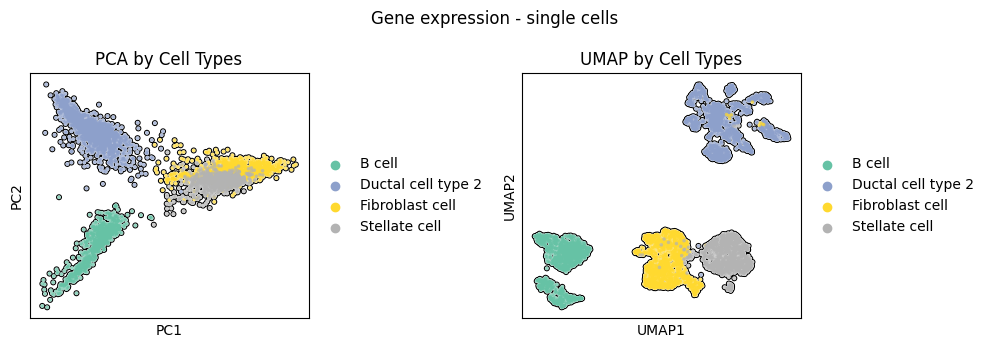

In [25]:
sc.pp.neighbors(adata_gExpr, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_gExpr)

fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

with rc_context({'figure.figsize': (3.5, 3.5)}):
    sc.pl.pca(adata_gExpr, color="Cell_Type", use_raw=False, palette="Set2", title="PCA by Cell Types", add_outline=True, ax=axs[0], show=False)
with rc_context({'figure.figsize': (3.5, 3.5)}):
    sc.pl.umap(adata_gExpr, color="Cell_Type", use_raw=False, palette="Set2", title="UMAP by Cell Types", add_outline=True, ax=axs[1], show=False)

plt.suptitle("Gene expression - single cells")
plt.tight_layout()

plt.show()


Visualize the cell population-specific metacells in PCA and UMAP embeddings.

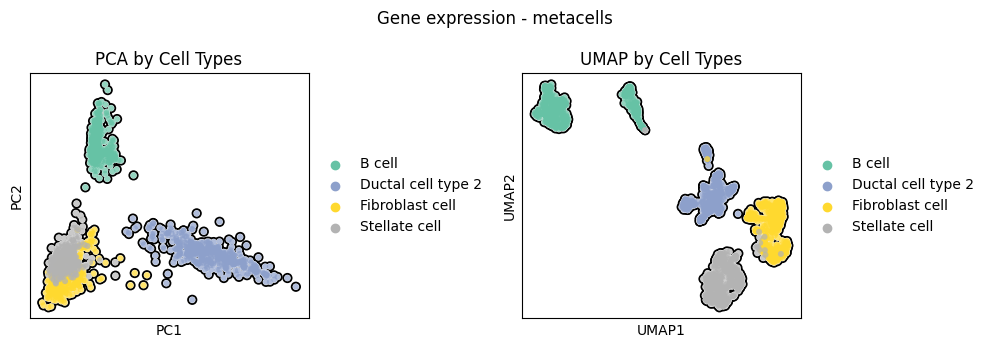

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

with rc_context({'figure.figsize': (3.5, 3.5)}):
    sc.pl.pca(adata_metacell, color="Cell_Type", use_raw=False, palette="Set2", title="PCA by Cell Types", add_outline=True, ax=axs[0], show=False)
with rc_context({'figure.figsize': (3.5, 3.5)}):
    sc.pl.umap(adata_metacell, color="Cell_Type", use_raw=False, palette="Set2", title="UMAP by Cell Types", add_outline=True, ax=axs[1], show=False)
plt.suptitle("Gene expression - metacells")
plt.tight_layout()

plt.show()

The cell type distribution is consistent between single-cells and metacells, with stellate cells and fibroblasts partially overlapping in the PCA as expected, and all the three lineages been separated along the directions of maximal variance.

### Key takeaways
<a id='4'></a>
This Tutorial describes how to generate metacells with pyVIPER. Metacells can be used for pseudo-bulk analysis of specific cellular populations or as input to [ARACNe](https://github.com/califano-lab/ARACNe3), when the original cell depth is not adequate to robustly infer regulatory networks (typically below 10,000 UMI/cell). The `repr_metacell` function computes several metacell-associated statistics and allows the users to specify several parameter combinations, among which the current Tutorial provides three examples.